In [2]:
import h5py
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.style as style
from scipy.ndimage import gaussian_filter
from scipy.signal import savgol_filter
from scipy import constants as cs
import numpy as np
from sklearn import preprocessing
from shabanipy.jj.utils import extract_switching_current
from shabanipy.jj.fraunhofer.deterministic_reconstruction import (extract_current_distribution)
from shabanipy.jj.fraunhofer.utils import find_fraunhofer_center, symmetrize_fraunhofer
import warnings


PROCESSED_DATA_FILE = 'JS311-MG2_pre-processed_data-198.hdf5'
SAMPLE = '2JJ-2HB-5MGJJ-MG2'
h = h5py.File(PROCESSED_DATA_FILE, 'r')
f = h['IcRn'][f'sample::{SAMPLE}']

In [3]:
PHI0 = cs.h / (2 * cs.e)  # magnetic flux quantum
JJ_WIDTH = 4e-6
# the effective junction length is largely unknown due to thin-film penetration
# depth and flux focusing effects; nominally 100nm
JJ_LENGTH = 1800e-9
FIELD_TO_WAVENUM = 2 * np.pi * JJ_LENGTH / PHI0  # B-field to beta wavenumber
PERIOD = 2 * np.pi / (FIELD_TO_WAVENUM * JJ_WIDTH)

In [4]:
keys = np.array(f)
keys = np.concatenate((keys[-1:],keys[:-1]))
data = {}
bias = {}
dIdV = {}
fft_dIdV = {}
dR = {}
out_field = np.array(f['In-plane Field::0']['Magnet Source - Source current'])/30

for key in keys:
    data[key] = np.array(f[key]["Voltage Drop"])
    bias[key] = np.array(f[key]["Bias"])
    dR[key] = np.array(f[key]["dR"])
    dIdV[key] = np.diff(np.array(f[key]["Voltage Drop"]))/np.diff(np.array(f[key]["Bias"]))

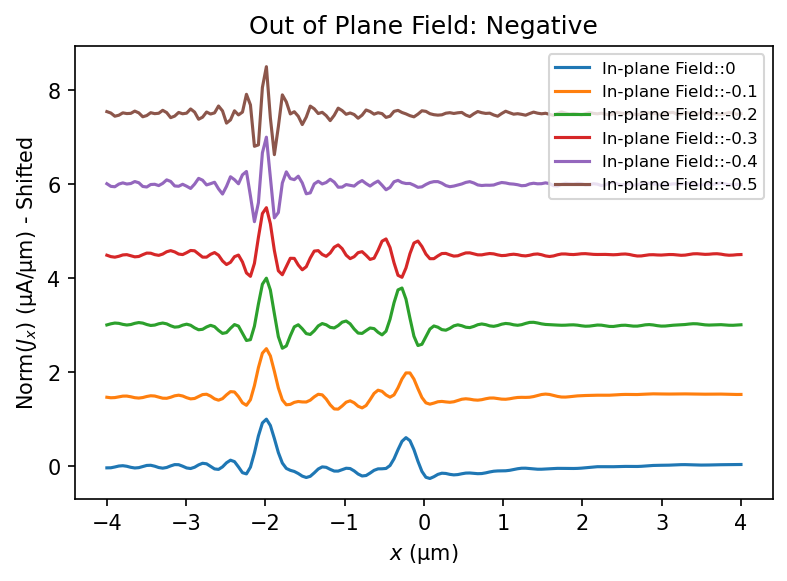

In [2]:
thre = np.array([2.95,2.95,3.15,3.25,3.5,3.5])*1e-3

plt.figure(dpi = 150)

for n, key in enumerate(keys[[0,4,8,12,16,20]]):
    ic = extract_switching_current(bias[key], data[key], threshold = thre[n], side = "positive")
    out_field_ = out_field[:,0] - find_fraunhofer_center(out_field[:,0], ic)
    out_field_, ic = symmetrize_fraunhofer(out_field_, ic)
    x, jx = extract_current_distribution(out_field_[:80], ic[:80], FIELD_TO_WAVENUM, JJ_WIDTH, len(out_field_[:80]))
    max_jx = max(jx)
    plt.plot(x*1e6,jx/max_jx+n*1.5, label = f'{key}')
    plt.xlabel(r'$x$ (µm)')
    plt.ylabel(r'Norm($J_{x}$) (µA/µm) - Shifted')
    plt.legend(loc = "upper right", prop = {'size' : 8})
    plt.title('Out of Plane Field: Negative')

#plt.savefig(f'figs/Jx_N_0.1_0.5-198.pdf')

In [7]:
plt.figure(dpi = 150)
for n, key in enumerate(keys[:4]):
    ic = extract_switching_current(bias[key], data[key], threshold = 2.95e-3, side = "positive")
    out_field_ = out_field[:,0] - find_fraunhofer_center(out_field[:,0], ic)
    out_field_, ic = symmetrize_fraunhofer(out_field_, ic)
    x, jx = extract_current_distribution(out_field_[:80]/30, ic[:80], FIELD_TO_WAVENUM, JJ_WIDTH, len(out_field_[:80]/30))
    max_jx = max(jx)
    plt.plot(x*1e6, jx/max_jx+n, label = f'{key}')
    plt.xlabel(r'$x$ (µm)')
    plt.ylabel(r'Norm($J_{x}$) (µA/µm) - Shifted')
    plt.legend(loc = "upper right", prop = {'size' : 8})
    plt.title('Out of Plane Field: Negative')

plt.savefig(f'figs/Jx_N_0_0.1-198.pdf')

TypeError: Improper input: N=3 must not exceed M=1

<Figure size 900x600 with 0 Axes>

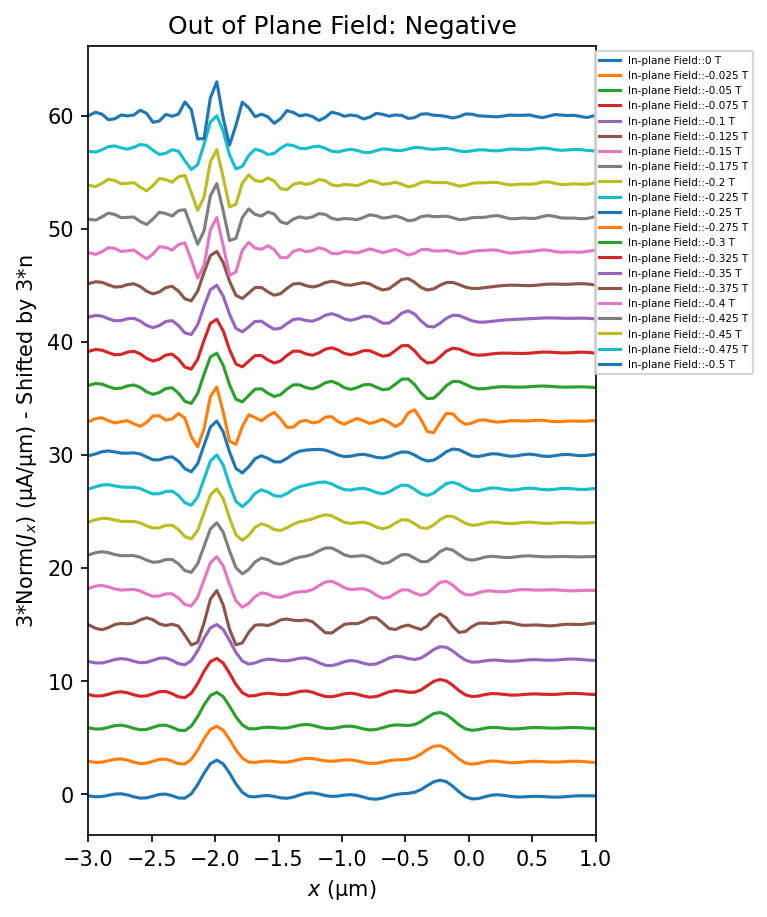

In [383]:
thre = np.array([2.95,2.95,2.95,2.95,2.95,2.95,2.95,2.95,
                 3.15,3.15,3.15,3.15,
                 3.25,3.25,3.25,3.25,
                 3.5, 3.5, 3.5, 3.8, 3.5])*1e-3

plt.figure(dpi = 150, constrained_layout = True,figsize=(5, 6))

for n, key in enumerate(keys):
    ic = extract_switching_current(bias[key], data[key], threshold = thre[n], side = "positive")
    out_field_ = out_field[:,0] - find_fraunhofer_center(out_field[:,0], ic)
    out_field_, ic = symmetrize_fraunhofer(out_field_, ic)
    x, jx = extract_current_distribution(out_field_[:80]/30, ic[:80], FIELD_TO_WAVENUM, JJ_WIDTH, len(out_field_[:80]/30))
    max_jx = max(jx)
    plt.plot(x*1e6,jx*3/max_jx+n*3, label = f'{key} T')
    plt.xlim(-3,1)
    plt.xlabel(r'$x$ (µm)')
    plt.ylabel(r'3*Norm($J_{x}$) (µA/µm) - Shifted by 3*n')
    plt.legend(loc = "upper right", prop = {'size' : 5},bbox_to_anchor=(1.32, 1))
    plt.title('Out of Plane Field: Negative')

plt.savefig(f'figs/Jx_N_0.1_all_0.5-198.pdf')


In [60]:
h.close()

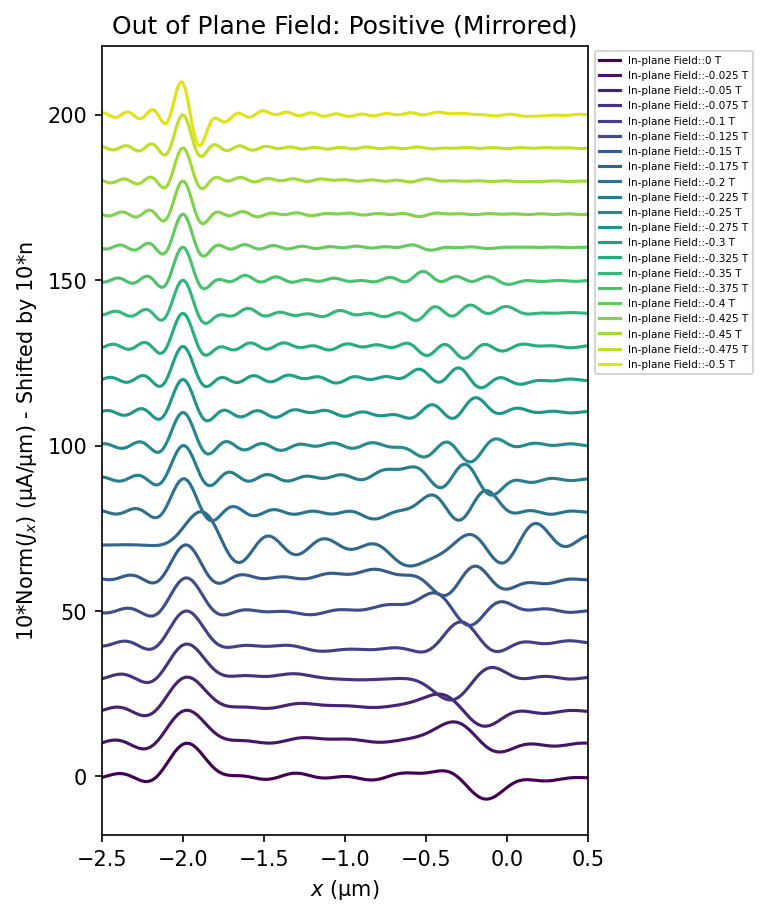

In [202]:
cmap = plt.get_cmap("viridis")
thre = np.array([2.95,2.95,2.95,2.95,2.95,2.95,2.95,2.95,
                 3.15,3.15,3.15,3.15,
                 3.25,3.25,3.25,3.25,
                 3.5, 3.5, 3.5, 3.8, 3.5])*1e-3
# thre = np.array([15,14,14,12,12,10,9,8,
#                  8,8,8,7,
#                  7,7,7,7,
#                  7, 6, 6, 6, 5])*1e-3

in_field = [float(key[16:]) for key in keys]
calc_shift = np.empty((6))

for n, key in enumerate(keys[:6]):
    ic = extract_switching_current(bias[key], data[key], threshold = thre[n], side = "positive")
    calc_shift[n] = find_fraunhofer_center(out_field[:,0], ic)


m,c = np.polyfit(in_field[:6],calc_shift,1)


linear_shift =  [(m*in_f +c) for in_f in in_field]

plt.figure(dpi = 150, constrained_layout = True,figsize=(5, 6))

for n, key in enumerate(keys):
    ic = extract_switching_current(bias[key], data[key], threshold = thre[n], side = "positive")
    pos_mirror_ic = np.concatenate((np.flip(ic[81:]),ic[80:]))
    neg_mirror_ic = np.concatenate((ic[:80],np.flip(ic[:81])))
    out_field_ = out_field[:,0] - linear_shift[n]
    out_field_, pos_mirror_ic = symmetrize_fraunhofer(out_field_, pos_mirror_ic)
    x, jx = extract_current_distribution(out_field_, pos_mirror_ic, FIELD_TO_WAVENUM, JJ_WIDTH, len(out_field_))
    max_jx = max(jx)
    plt.plot(x*1e6,10*jx/max_jx + 10*n, label = f'{key} T',color = cmap(n/len(keys)))
    plt.xlim(-2.5,0.5)
    plt.xlabel(r'$x$ (µm)')
    plt.ylabel(r'10*Norm($J_{x}$) (µA/µm) - Shifted by 10*n')
    #plt.ylabel(r'$J_{x}$ (µA/µm)')
    plt.legend(loc = "upper right", prop = {'size' : 5},bbox_to_anchor=(1.35, 1))
    #plt.title('Out of Plane Field: Positive = Negative - Linear Shift Applied')
    plt.title('Out of Plane Field: Positive (Mirrored)')



plt.savefig('figs/Jx_P_all_out_lin_shift_plotNormshifted.pdf')
#plt.savefig('figs/Jx_N_all_out_lin_shift.pdf')
# plt.savefig('figs/Jx_PN_all.pdf')